# Telecom Customer Behavior Analysis

# Overview

# Business Problem

# Data Understanding

The available data comes from a telecom compoany's record of customer information. In this analysis, I examine features that are likely to play a role in customer churn. They include:

- State
- Account Length (in months)
- Area Code
- International Plan (y/n)
- Voice Mail Plan (y/n)
- No. of Voicemail Messages
- Total Day Minutes, Calls, and Charges
- Total Evening Minutes, Calls, and Charges
- Total Night Minutes, Calls, and Charges
- Total International Minutes, Calls, and Charges
- No. of Customer Service Calls

# Data Analysis

## Preparation and EDA

Before we begin the iterative modeling process, we need to take a look at the data to better understand its structure features. We will check for outliers, visualize our target and some correlations, and build some pipelines to speed up preprocessing down the line.

In [2]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, \
StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [3]:
# Loading dataset
df = pd.read_csv('data/customer_churn_data.csv')

# Priting first 5 rows
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


All our data is nicely laid out for us. Right off the bat, I notice that our target column is currently categorical, so we will want to transform that into binary down the line. There is also definitely a large majority of numeric columns, with only a single truly categorical one (state).

The next step is to check for missing values, which I can do below:

In [4]:
# Printing dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

No missing values! That's a plus. For preprocessing, we'll need to know which columns are numeric and which are categorical. For the categorica columns, we need to take a look and see what we're going to do with them.

It also appears that our target column ("churn") is a categorical boolean. We can change this to 1s and 0s by casting the whole column as an integer.

Customer phone numbers won't be too useful in this case, so we can drop that column. For two other categorical features (international plan and voice mail plan), we can also make those binary choices into 1s and 0s. That way, we don't have to bother one-hot encoding them later.

In [5]:
# Casting churn as an integer
df['churn'] = df['churn'].astype(int)

In [6]:
# Dropping phone number column
df = df.drop('phone number', axis=1)

In [7]:
# Replacing two string columns with integers
df[['international plan', 'voice mail plan']] = df[['international plan', 'voice mail plan']].replace(
    {'yes': 1, "no": 0})

Now that we've better organized our data, we can check out some correlation values.

<AxesSubplot:>

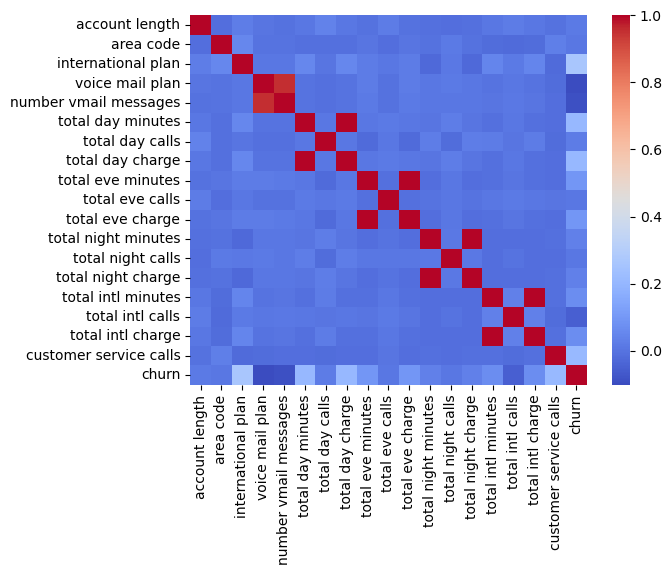

In [9]:
# Creating correlation heatmap
df_corrs = df.corr()
sns.heatmap(df_corrs, cmap='coolwarm')

This seems like a fairly normal correlation chart. We see that red diagonal streak, which is caused by identical variables correlating perfectly with each other. The red squares surrounding the streak is likely caused by strong correlations between calls, minutes, and charge for each time of day.

On the bottom row, you can see that certain features have slightly higher correlations with churn. The two that stand out to me are customer service calls and having an international plan. More customer service calls would make sense because those normally are a product of customer dissatisfaction. Having an international plan might lead to higher charges or more headache, so that could be another common cause for churn. We can take a closer look at the numerical value of these correlations below:

In [9]:
numeric_cols = df.drop('state', axis=1)
numeric_cols.corrwith(df['churn']).sort_values(ascending=False)

churn                     1.000000
international plan        0.259852
customer service calls    0.208750
total day minutes         0.205151
total day charge          0.205151
total eve minutes         0.092796
total eve charge          0.092786
total intl charge         0.068259
total intl minutes        0.068239
total night charge        0.035496
total night minutes       0.035493
total day calls           0.018459
account length            0.016541
total eve calls           0.009233
area code                 0.006174
total night calls         0.006141
total intl calls         -0.052844
number vmail messages    -0.089728
voice mail plan          -0.102148
dtype: float64

Indeed, an international plan and customer service calls are the two largest indicators of churn. Total day minutes and the associated charges are also correlated, indicating that perhaps some customers are switching providers for better value on their day minutes.

We can take a look at some key statistics for the entire dataset below:

In [10]:
df.describe()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


We can see that the average customer has been using this company as their provider for 101 months, which is just under eight and a half years. Of these customers, about 10% have an international plan. The average customer also makes about 1.5 customer service calls.

Let's make a quick visualization of the tatget column.

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

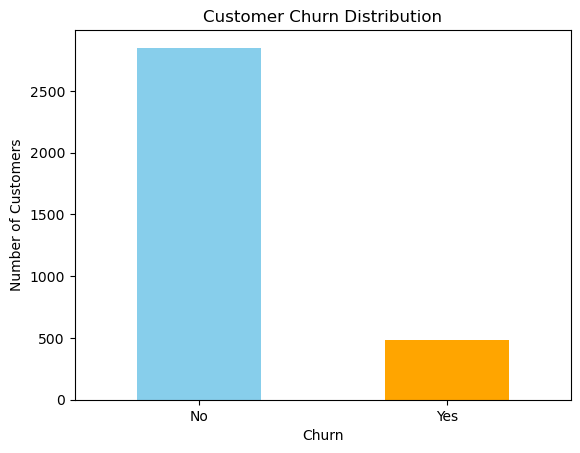

In [11]:
churn_counts = df['churn'].value_counts()

fig, ax = plt.subplots()
churn_counts.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
ax.set_title('Customer Churn Distribution')
ax.set_xlabel('Churn')
ax.set_ylabel('Number of Customers')
ax.set_xticklabels(['No', 'Yes'], rotation=0)

In [ ]:
churn_rate_by_state = df.groupby('state')['churn'].mean() * 100

churn_rate_by_state_df = churn_rate_by_state.reset_index()

churn_rate_by_state_df.columns = ['State', 'Churn Rate']

churn_rate_by_state_df.columns = ['State', 'Churn Rate']

churn_rate_by_state_df.sort_values(by='Churn Rate', ascending=False)

In [81]:
import plotly.express as px

fig = px.choropleth(churn_rate_by_state_df,
                    locations='State',  
                    locationmode='USA-states',
                    color='Churn Rate',
                    hover_name='State',
                    color_continuous_scale=px.colors.sequential.Sunsetdark,
                    scope='usa',
                    title='Churn Rate by State')
fig.show()

Based on the bar chart above and the target mean, it seems that the majority of the target cases are 0s, or the negative case. We can confirm this by checking the value counts below:

In [12]:
(df['churn'].value_counts()/3333) * 100

0    85.508551
1    14.491449
Name: churn, dtype: float64

Indeed, it looks like we have a pretty large class imbalance within the target column. The negative case makes up 85.5% of the total cases in the dataset. This means that, if we made a model that only guessed the negative case every time, we would already wind up with 85.5% accuracy! That's no good. We can change this by resampling the data to make it more even. However, to avoid data leakage, let's first split the data into train and test sets. After that, we can set up some handy pipelines to preprocess our data before feeding it into some models.

In [91]:
# Defining target and predictors
y = df['churn']

X = df.drop('churn', axis=1)

time: 3.14 ms (started: 2024-02-26 13:14:56 -05:00)


In [92]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

time: 6.65 ms (started: 2024-02-26 13:14:56 -05:00)


In [93]:
# Checking for class imbalance after split
print((y_train.value_counts()/len(y_train)) * 100)

print((y_test.value_counts()/len(y_test)) * 100)

0    85.67427
1    14.32573
Name: churn, dtype: float64
0    85.01199
1    14.98801
Name: churn, dtype: float64
time: 6.86 ms (started: 2024-02-26 13:14:57 -05:00)


As we can see, the target ratios are still imbalanced after the split. Now, we can go about building some pipelines to rectify that!

In [94]:
# Creating numeric scaling pipeline
numeric_pipe = Pipeline(steps=[('scaler', StandardScaler())])

# Creating one-hot encoding pipeline
categorical_pipe = Pipeline([('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))])

time: 624 µs (started: 2024-02-26 13:14:57 -05:00)


We've created two separate pipelines. One will apply standard scaling to any columns it encounters, and the other will one-hot encode. Now, we can combine these columns to sort the data into the different subpipelines for processing.

In [95]:
# Combining pipelines to handle all columns
preprocessing_pipe = ColumnTransformer(transformers=[
                                        ('numeric_pipe', numeric_pipe, 
                                         make_column_selector(dtype_include=['int', 'float'])), 
    
                                        ('categorical_pipe', categorical_pipe, 
                                         make_column_selector(dtype_include='object'))])

time: 889 µs (started: 2024-02-26 13:14:57 -05:00)


The column transformer above will work to preprocess our data for us. For rebalancing our target samples, we have to use a different pipeline, which we will create once we begin modeling.

# Preliminary Modeling

In [96]:
# Loading execution timer
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.31 ms (started: 2024-02-26 13:14:57 -05:00)


## Logistic Regression

Now that we have our preprocessing pipeline, we can forego a lot of the manual preprocessing steps and just use our trusty pipelines! We're going to make a new pipeline here that incorporates a Synthetic Minority Over-sampling Technique, or SMOTE. This will balance out the target samples, making our model's results more significant. 

Note that, for logistic regressions, we are going to be scaling our data. For future models, we may not need to.

In [97]:
# Creating logistic regression pipeline
logreg_pipe = ImPipeline(steps=[('preprocessor', preprocessing_pipe), # Our preprocessing pipe from above
                                   ('sm', SMOTE(random_state=42)), # Resamples target
                                   ('logreg', LogisticRegression(solver='liblinear', random_state=42))]) # Runs regression

time: 751 µs (started: 2024-02-26 13:14:58 -05:00)


The pipeline above allows us to automate all our preprocessing, resampling, and modeling steps. As you will see below, the pipeline will automatically bin the data and process it as needed, ignoring unecessary methods for each step.

In [98]:
# Fitting regression to training data
logreg_model = logreg_pipe.fit(X_train, y_train)
logreg_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a14e5700>),
                                                 ('categorical_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a14e5d60>)])),
                ('sm', SMOTE(random_state=42)),
                ('logreg',
                 LogisticRegression(random_state=42, solver='liblinear'))])

time: 62.5 ms (started: 2024-02-26 13:14:58 -05:00)


In [99]:
# Scoring model on training data
logreg_model.score(X_train, y_train)

0.7799119647859144

time: 6.82 ms (started: 2024-02-26 13:14:58 -05:00)


In [100]:
# Getting predictions on test set
logreg_y_pred = logreg_model.predict(X_test)

time: 10.6 ms (started: 2024-02-26 13:14:58 -05:00)


In [101]:
# Printing various metrics on test data
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       709
           1       0.37      0.78      0.50       125

    accuracy                           0.77       834
   macro avg       0.66      0.77      0.68       834
weighted avg       0.86      0.77      0.80       834

time: 7.29 ms (started: 2024-02-26 13:14:59 -05:00)


Our logistic regression classifier leaves plenty to be desired. It performs similarly on both the training and test data, with an accuracy score of around 77% on both. An important point is that it consistently fails to identify positive cases in the test set. This is a problem because we want the model to accurately predict positive cases, because false negatives will lead to unexpected churn numbers over time.

## Decision Tree

The next model we will try is a simple decision tree. For this model, we do not need to scale our data because the model will perform splits the same way no matter the scale. Therefore, this time around, we only need a one-hot encoder as our preprocessor. 

In [104]:
# Creating preprocessing pipeline
dec_tree_preprocessor = ColumnTransformer(transformers=[
                                          ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'), 
                                           [0])], remainder='passthrough')

time: 644 µs (started: 2024-02-26 13:41:25 -05:00)


In [105]:
# Creating decision tree pipeline
dec_tree_pipe = ImPipeline(steps=[('ohe', dec_tree_preprocessor),
                                  ('sm', SMOTE(random_state=42)),
                                  ('tree', DecisionTreeClassifier(random_state=42))])

time: 1.29 ms (started: 2024-02-26 13:41:25 -05:00)


In [106]:
# Fitting model to training data
dec_tree_model = dec_tree_pipe.fit(X_train, y_train)
dec_tree_model

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [0])])),
                ('sm', SMOTE(random_state=42)),
                ('tree', DecisionTreeClassifier(random_state=42))])

time: 101 ms (started: 2024-02-26 13:41:25 -05:00)


In [27]:
# Scoring model on training data
dec_tree_model.score(X_train, y_train)

1.0

time: 4.48 ms (started: 2024-02-26 11:34:08 -05:00)


### ^Red flag!^

A perfect score on the training data indicates that the model is very likely overfitting, picking up noise in the training set that will not generalize well to unseen data. Let's confirm this assumption below.

In [107]:
# Getting predictions on test set
dec_tree_y_pred = dec_tree_model.predict(X_test)

time: 12.2 ms (started: 2024-02-26 13:43:43 -05:00)


In [108]:
# Printing various metrics on test data
print(classification_report(y_test, dec_tree_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       709
           1       0.66      0.78      0.72       125

    accuracy                           0.91       834
   macro avg       0.81      0.86      0.83       834
weighted avg       0.92      0.91      0.91       834

time: 9.04 ms (started: 2024-02-26 13:43:54 -05:00)


As expected, we do see some overfitting going on, although the model actually performs quite well on the test set overall. We see an f1 score of 91% which is excellent, as well as a vastly improved recall for both positive and negative cases. Our recall for the positive case continues to be a problem, and we can see that predictions on the positive case are consistently far lower than on the negative case. For our next model, we will try to solve this by applying an ensemble method.

## Random Forest

Our final base model will be an ensemble method that makes use of many decision trees, employing a voting system for making predictions on each data point. Just like before, we won't need scaling steps here, only preprocessing for our categorical "state" column.

In [115]:
# Creating random forest pipeline
random_forest_pipe = ImPipeline(steps=[('ohe', dec_tree_preprocessor),
                                  ('sm', SMOTE(random_state=42)),
                                  ('tree', RandomForestClassifier(random_state=42))])

time: 891 µs (started: 2024-02-26 14:18:23 -05:00)


In [116]:
# Fitting to training data
random_forest_model = random_forest_pipe.fit(X_train, y_train)

time: 576 ms (started: 2024-02-26 14:18:23 -05:00)


Notice the time stamp for the cell above. We can see as I fit this model that it takes more than 5 times as long to fit as our normal decision tree and about 50 times as long as our logistic regression! This is due to the model's complexity; it has to run many decision trees in parallel, then aggregating assessments and voting on what the right answer should be.

In [111]:
# Scoring model on training data
random_forest_model.score(X_train, y_train)

1.0

time: 25.2 ms (started: 2024-02-26 13:47:32 -05:00)


Again we see a perfect score on the training data. This indicates another instance of overfitting. This time around, however, we should see a smaller disparity between the training and test data.

In [112]:
# Getting predictions on test set
random_forest_y_pred = random_forest_model.predict(X_test)

time: 11 ms (started: 2024-02-26 13:47:32 -05:00)


In [113]:
# Printing various metrics on test data
print(classification_report(y_test, random_forest_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       709
           1       0.83      0.70      0.76       125

    accuracy                           0.93       834
   macro avg       0.89      0.84      0.86       834
weighted avg       0.93      0.93      0.93       834

time: 6.59 ms (started: 2024-02-26 13:47:33 -05:00)


While the model is still overfit, we see slight improvement in the model's overall. Interestingly enough, while precision increases here compared to the base decision tree, recall drops for the positive case. This is something we want to try and rectify in our final, tuned model. As a basis for one of our hyperparameters, we can take a look under the hood and see how deep each tree is going. This will help us make decisions on the range of hyperparameter values to test.

In [122]:
# Getting individual tree steps
steps = random_forest_pipe.named_steps['tree']

trees = steps.estimators_

depths = []

# Pulling depths for each tree
for i, tree in enumerate(trees):
    depth = tree.get_depth()
    depths.append(depth)
    print(f"Tree {i+1}: Depth = {depth}")

print("")
print("Average Depth: ", sum(depths)/len(depths))

Tree 1: Depth = 20
Tree 2: Depth = 30
Tree 3: Depth = 25
Tree 4: Depth = 23
Tree 5: Depth = 23
Tree 6: Depth = 24
Tree 7: Depth = 32
Tree 8: Depth = 26
Tree 9: Depth = 23
Tree 10: Depth = 25
Tree 11: Depth = 29
Tree 12: Depth = 24
Tree 13: Depth = 34
Tree 14: Depth = 29
Tree 15: Depth = 30
Tree 16: Depth = 23
Tree 17: Depth = 29
Tree 18: Depth = 26
Tree 19: Depth = 31
Tree 20: Depth = 27
Tree 21: Depth = 25
Tree 22: Depth = 25
Tree 23: Depth = 27
Tree 24: Depth = 23
Tree 25: Depth = 33
Tree 26: Depth = 25
Tree 27: Depth = 27
Tree 28: Depth = 25
Tree 29: Depth = 32
Tree 30: Depth = 29
Tree 31: Depth = 26
Tree 32: Depth = 25
Tree 33: Depth = 24
Tree 34: Depth = 24
Tree 35: Depth = 22
Tree 36: Depth = 24
Tree 37: Depth = 28
Tree 38: Depth = 24
Tree 39: Depth = 27
Tree 40: Depth = 24
Tree 41: Depth = 22
Tree 42: Depth = 28
Tree 43: Depth = 26
Tree 44: Depth = 26
Tree 45: Depth = 28
Tree 46: Depth = 36
Tree 47: Depth = 25
Tree 48: Depth = 24
Tree 49: Depth = 31
Tree 50: Depth = 28
Tree 51: 

Over 100 iterations, our average depth is 26.28. During the fine-tuning process, we can tinker with this number to see what becomes the optimal value for our target performance metrics.

# Final Model

Our final model will be a tuned version of the random forest method we just ran. The tuning process will consist of changes iterated over several sets of hyperparameter categories. GridSearchCV will run these iterations, finding the specific set of hyperparameters that lead to optimal performance for a given scoring metric. I will be optimizing for recall since that is the most important metric for stakeholders in this particular case and because it seems we are already achieving excellent accuracy and f1 scores.

## Tuning

The grid below consists of ranges for four hyperparameters. First, we set the number of estimators, or how many trees we want to be in the forest. Next, we have our max tree depth, which we took a peek at above. Since the average is 26.28, I have tried to concentrate my parameters around that to see if we can find a more optimal number.

Next up is the minimal samples split, or the minimum number of samples required to split a node. I am casting a wide net with the hyperparameter values here. Finally, we have min_samples_leaf, or the minimal number of samples required to be in a leaf node. I think I want to keep the values low for this one, so I am running one through five.

For my grid search, I will be running my random forest model from above, cross-validating with five folds, and using all my available CPU cores (12) to run multiple models at once. This should significantly decrease fitting time.

In [125]:
param_grid = {
    'tree__n_estimators': [100, 150, 200, 250, 300],
    'tree__max_depth': [None, 10, 15, 18, 20, 22, 25, 27, 30],
    'tree__min_samples_split': [2, 5, 8, 10, 12],
    'tree__min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(random_forest_pipe, param_grid, cv=5, scoring='recall', n_jobs=12)

grid_search_model = grid_search.fit(X_train, y_train)

time: 7min 30s (started: 2024-02-26 14:59:54 -05:00)


Done! This search took seven and a half minutes to run, which makes sense given the amount of calculations it had to do for every combination of hyperparameters. Now that we have the best fit, we can take a look at what hyperparameters the model recommends:

In [127]:
print('Best Hyperparameters: ', grid_search.best_params_)

Best Hyperparameters:  {'tree__max_depth': None, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2, 'tree__n_estimators': 250}
time: 829 µs (started: 2024-02-26 15:09:00 -05:00)


So, the optimal model based on these inputs has:
- No max tree depth
- A one-sample minimum for leaf nodes
- A minimum sample of 2 for a split
- 250 decision trees voting

Now, we can just enter those hyperparameters into our original pipeline and fit the model again!

In [130]:
tuned_rf_pipe = random_forest_pipe = ImPipeline(steps=[('ohe', dec_tree_preprocessor),
                                  ('sm', SMOTE(random_state=42)),
                                  ('tree', RandomForestClassifier(max_depth=None, min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                n_estimators=250, 
                                                                random_state=42))])

time: 1.85 ms (started: 2024-02-26 15:13:08 -05:00)


In [131]:
final_model = tuned_rf_pipe.fit(X_train, y_train)

final_model_train_preds = final_model.predict(X_train)

print(f1_score(y_train, final_model_train_preds))

final_model_y_preds = final_model.predict(X_test)

print(classification_report(y_test, final_model_y_preds))

1.0
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       709
           1       0.81      0.70      0.75       125

    accuracy                           0.93       834
   macro avg       0.88      0.84      0.86       834
weighted avg       0.93      0.93      0.93       834

time: 1.46 s (started: 2024-02-26 15:13:10 -05:00)


In [41]:
final_model.estimators_

AttributeError: 'Pipeline' object has no attribute 'estimators_'

time: 19.1 ms (started: 2024-02-26 11:48:04 -05:00)


## Evaluation

## Feature Importances

# Conclusions

## Next Steps

## Contact Information

In [123]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

Number of CPU cores: 12
time: 1.64 ms (started: 2024-02-26 14:54:11 -05:00)


Number of CPU cores: 12
time: 809 µs (started: 2024-02-26 11:48:51 -05:00)
